## Dependencies

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from models import CNN, build_resnet
from gaf import GAF
from train import train_model
import os
from pathlib import Path
from utils import ECGDataset, plot_classifier_curves, plot_gaf_samples,plot_gaf_both, evaluate_classifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

torch.manual_seed(42)
os.makedirs('./logs/',exist_ok=True)
os.makedirs('./saved_models',exist_ok=True)

# Model 1: CNN - GASF
log_path_1 = Path('./logs/cnn_gasf.csv')
model_path_1 = Path('./saved_models/cnn_gasf.pt')

# Model 2: CNN - GADF
log_path_2 = Path('./logs/cnn_gadf.csv')
model_path_2 = Path('./saved_models/cnn_gadf.pt')

# Model 3: CNN - GASF + GADF
log_path_3 = Path('./logs/cnn_both.csv')
model_path_3 = Path('./saved_models/cnn_both.pt')

# Model 4: ResNet - GASF + GADF
log_path_4 = Path('./logs/resnet_both.csv')
model_path_4 = Path('./saved_models/resnet_both.pt')

# Parameters
BATCH_SIZE=32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class_names = ['N','S','V','F','Q']

### Load Dataset

In [2]:
# Load datasets
train_data = pd.read_csv('../data/ecg_signals/mitbih_train.csv', header=None)
test_data = pd.read_csv('../data/ecg_signals/mitbih_test.csv', header=None)

# Extract features and labels
X = train_data.iloc[:, :-1].values
y = train_data.iloc[:, -1].astype(int).values

rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y,shuffle=True,random_state=42)

# Load test set
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].astype(int).values
# X_test,y_test = rus.fit_resample(X_test,y_test)

C:\Users\harsh\AppData\Local\Temp\ipykernel_21056\663069994.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_mapping.values()), y=counts, palette="viridis")


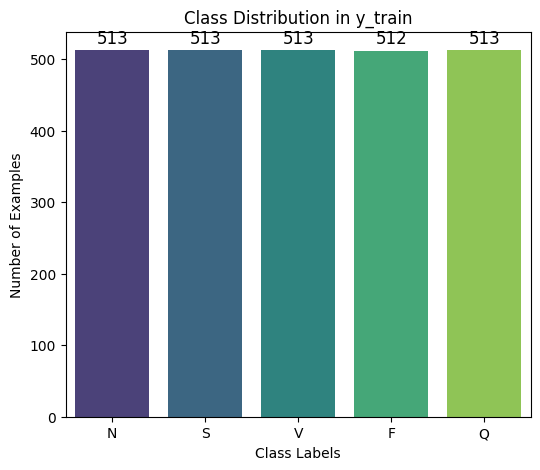

In [3]:
# Class label mapping
class_mapping = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

# Count occurrences of each class
unique_classes, counts = np.unique(y_train, return_counts=True)


# Plot class distribution
plt.figure(figsize=(6, 5))
sns.barplot(x=list(class_mapping.values()), y=counts, palette="viridis")

# Add labels
plt.xlabel("Class Labels")
plt.ylabel("Number of Examples")
plt.title("Class Distribution in y_train")

# Show values on bars
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', fontsize=12)

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

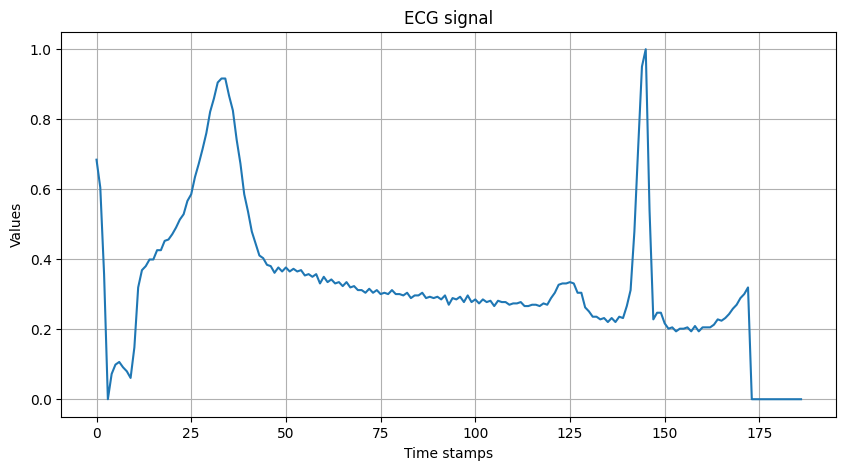

In [11]:
signal = X_train[0]

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(signal)),signal)
plt.title("ECG signal")
plt.xlabel("Time stamps")
plt.ylabel("Values")
plt.grid(True)
plt.show

In [12]:
signal

array([0.68441063, 0.60456276, 0.35741445, 0.        , 0.07224335,
       0.09885932, 0.10646388, 0.09125476, 0.07984791, 0.0608365 ,
       0.14828898, 0.31939164, 0.36882129, 0.38022813, 0.39923954,
       0.39923954, 0.42585552, 0.42585552, 0.45247149, 0.45627376,
       0.4714829 , 0.49049431, 0.51330799, 0.52851713, 0.56653994,
       0.58555132, 0.63498098, 0.67300379, 0.71482891, 0.76045626,
       0.82129276, 0.85931557, 0.90494299, 0.91634983, 0.91634983,
       0.86692017, 0.82509506, 0.74144489, 0.67300379, 0.58555132,
       0.53612167, 0.47908744, 0.44486693, 0.41064638, 0.40304184,
       0.38403043, 0.38022813, 0.36121672, 0.37642586, 0.36501902,
       0.37642586, 0.36501902, 0.37262356, 0.36501902, 0.36882129,
       0.35361215, 0.35741445, 0.34980989, 0.35741445, 0.33079848,
       0.34980989, 0.33460075, 0.34220532, 0.33079848, 0.33460075,
       0.32319391, 0.33460075, 0.31939164, 0.32319391, 0.31178707,
       0.31178707, 0.3041825 , 0.31558937, 0.3041825 , 0.31178

## Exploratory Data Analysis

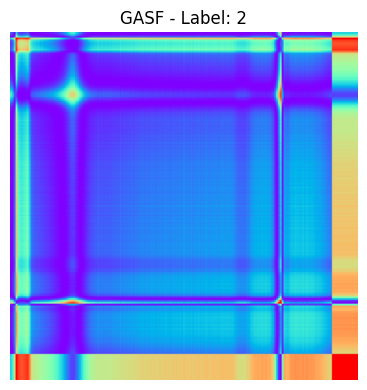

In [4]:
train_dataset_gasf = ECGDataset(X_train, y_train,gaf_mode='gasf')

plot_gaf_samples(dataset=train_dataset_gasf,num_samples=1,cols=1)


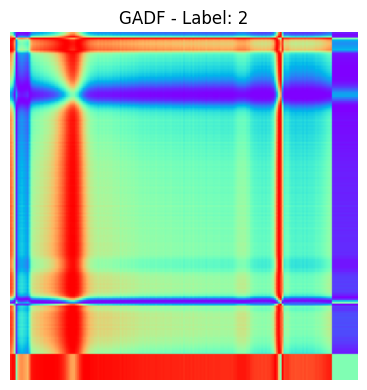

In [5]:
train_dataset_gadf = ECGDataset(signals=X_train,labels=y_train,gaf_mode='gadf')
plot_gaf_samples(dataset=train_dataset_gadf,num_samples=1,cols=1,gaf_type='GADF')

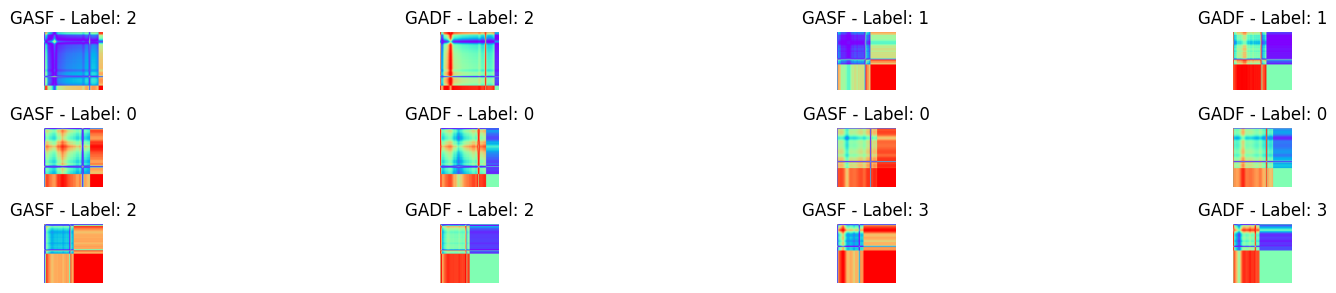

In [6]:
train_dataset_both = ECGDataset(signals=X_train,labels=y_train)
plot_gaf_both(dataset=train_dataset_both,num_samples=6,cols=4,gaf_type='GASF + GADF')

## Model 1 - CNN - GASF

In [7]:
train_dataset = ECGDataset(signals=X_train,
                           labels=y_train,
                           gaf_mode='gasf')
val_dataset = ECGDataset(signals=X_val,
                         labels=y_val,
                         gaf_mode='gasf')
test_dataset = ECGDataset(signals=X_test,
                          labels=y_test,
                          gaf_mode='gasf')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE)
test_loader_1 = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE)


model_1 = CNN()
train_model(model=model_1,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            num_epochs=20,
            log_path=log_path_1,
            model_path=model_path_1,
            patience=2)

Epoch 1/20 | Train Loss: 0.9075 | Train Acc: 0.6595 | Val Loss: 0.6464 | Val Acc: 0.7676 | Patience: 0
Epoch 2/20 | Train Loss: 0.5672 | Train Acc: 0.7855 | Val Loss: 0.5238 | Val Acc: 0.8112 | Patience: 0
Epoch 3/20 | Train Loss: 0.4414 | Train Acc: 0.8401 | Val Loss: 0.4758 | Val Acc: 0.8268 | Patience: 0
Epoch 4/20 | Train Loss: 0.3582 | Train Acc: 0.8674 | Val Loss: 0.4336 | Val Acc: 0.8549 | Patience: 0
Epoch 5/20 | Train Loss: 0.2949 | Train Acc: 0.8916 | Val Loss: 0.4395 | Val Acc: 0.8549 | Patience: 0
Epoch 6/20 | Train Loss: 0.2407 | Train Acc: 0.9115 | Val Loss: 0.4614 | Val Acc: 0.8627 | Patience: 1
Epoch 7/20 | Train Loss: 0.2149 | Train Acc: 0.9208 | Val Loss: 0.5252 | Val Acc: 0.8627 | Patience: 0
Epoch 8/20 | Train Loss: 0.1530 | Train Acc: 0.9450 | Val Loss: 0.4593 | Val Acc: 0.8721 | Patience: 1
Epoch 9/20 | Train Loss: 0.1075 | Train Acc: 0.9614 | Val Loss: 0.5213 | Val Acc: 0.8580 | Patience: 0
Epoch 10/20 | Train Loss: 0.0792 | Train Acc: 0.9719 | Val Loss: 0.5367 |

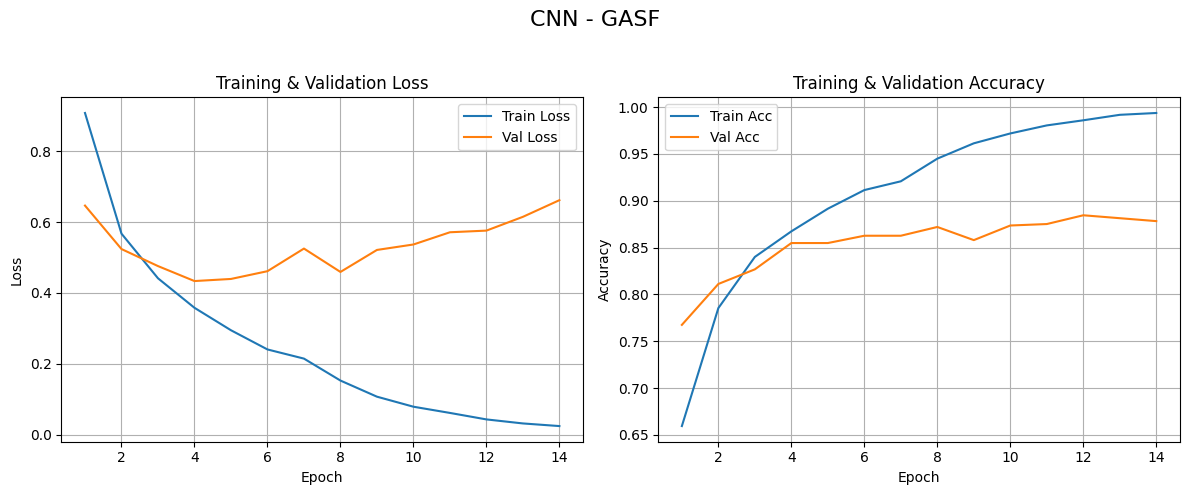

Accuracy: 0.8615
Classification Report:
               precision    recall  f1-score   support

           N       0.99      0.85      0.92     18118
           S       0.24      0.79      0.37       556
           V       0.72      0.87      0.79      1448
           F       0.17      0.91      0.29       162
           Q       0.86      0.95      0.90      1608

    accuracy                           0.86     21892
   macro avg       0.60      0.88      0.65     21892
weighted avg       0.94      0.86      0.89     21892



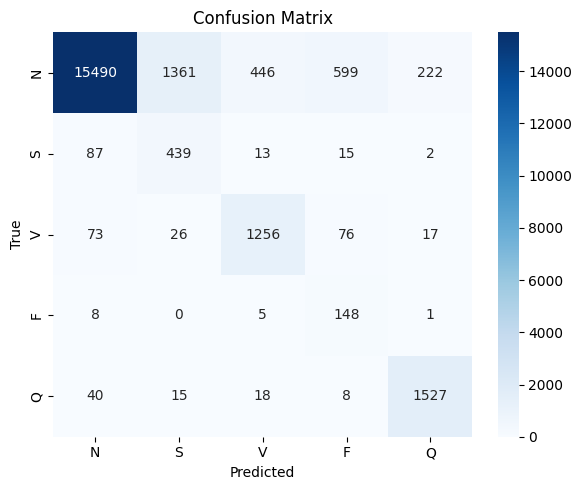

In [8]:
plot_classifier_curves(
    log_path=log_path_1,
    suptitle='CNN - GASF'
)

evaluate_classifier(
    model=model_1,
    dataloader=test_loader_1,
    class_names=class_names,
    device=device
)

## Model 2: CNN - GADF

In [9]:
train_dataset = ECGDataset(signals=X_train,
                           labels=y_train,
                           gaf_mode='gadf')
val_dataset = ECGDataset(signals=X_val,
                         labels=y_val,
                         gaf_mode='gadf')
test_dataset = ECGDataset(signals=X_test,
                          labels=y_test,
                          gaf_mode='gadf')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE)
test_loader_2 = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE)


model_2 = CNN()
train_model(model=model_2,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            num_epochs=20,
            log_path=log_path_2,
            model_path=model_path_2,
            patience=2)

Epoch 1/20 | Train Loss: 0.8589 | Train Acc: 0.6685 | Val Loss: 0.6264 | Val Acc: 0.7722 | Patience: 0
Epoch 2/20 | Train Loss: 0.5330 | Train Acc: 0.8058 | Val Loss: 0.5645 | Val Acc: 0.7910 | Patience: 0
Epoch 3/20 | Train Loss: 0.4142 | Train Acc: 0.8471 | Val Loss: 0.4869 | Val Acc: 0.8237 | Patience: 0
Epoch 4/20 | Train Loss: 0.3459 | Train Acc: 0.8768 | Val Loss: 0.4157 | Val Acc: 0.8596 | Patience: 0
Epoch 5/20 | Train Loss: 0.2670 | Train Acc: 0.9009 | Val Loss: 0.3968 | Val Acc: 0.8674 | Patience: 0
Epoch 6/20 | Train Loss: 0.2129 | Train Acc: 0.9239 | Val Loss: 0.3922 | Val Acc: 0.8658 | Patience: 0
Epoch 7/20 | Train Loss: 0.1793 | Train Acc: 0.9380 | Val Loss: 0.3811 | Val Acc: 0.8736 | Patience: 1
Epoch 8/20 | Train Loss: 0.1455 | Train Acc: 0.9458 | Val Loss: 0.3806 | Val Acc: 0.8721 | Patience: 0
Epoch 9/20 | Train Loss: 0.1126 | Train Acc: 0.9629 | Val Loss: 0.4239 | Val Acc: 0.8674 | Patience: 1
Early stopping triggered!


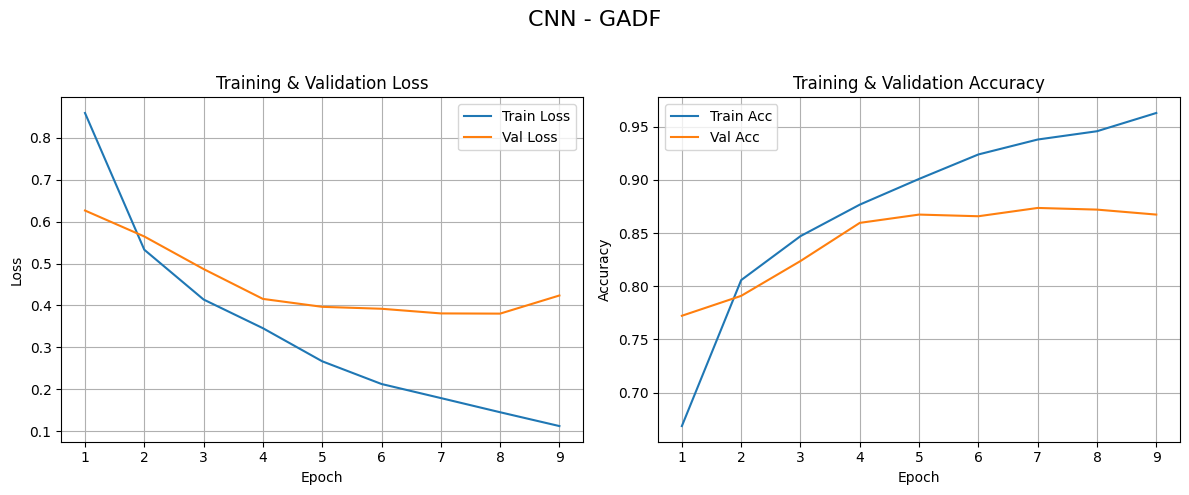

Accuracy: 0.8808
Classification Report:
               precision    recall  f1-score   support

           N       0.99      0.88      0.93     18118
           S       0.37      0.74      0.49       556
           V       0.77      0.88      0.82      1448
           F       0.13      0.92      0.22       162
           Q       0.85      0.96      0.90      1608

    accuracy                           0.88     21892
   macro avg       0.62      0.88      0.67     21892
weighted avg       0.94      0.88      0.90     21892



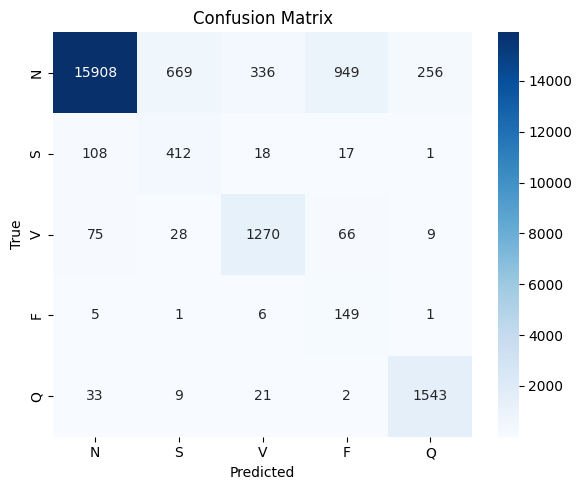

In [10]:
plot_classifier_curves(log_path=log_path_2,suptitle='CNN - GADF')

evaluate_classifier(
    model=model_2,
    dataloader=test_loader_2,
    class_names=class_names,
    device=device
)

## Model 3: CNN - both

In [11]:
train_dataset = ECGDataset(signals=X_train,
                           labels=y_train,
                           gaf_mode='both')
val_dataset = ECGDataset(signals=X_val,
                         labels=y_val,
                         gaf_mode='both')
test_dataset = ECGDataset(signals=X_test,
                          labels=y_test,
                          gaf_mode='both')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE)
test_loader_3 = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE)


model_3 = CNN(in_channels=2)
train_model(model=model_3,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            num_epochs=20,
            log_path=log_path_3,
            model_path=model_path_3,
            patience=2)

Epoch 1/20 | Train Loss: 0.8630 | Train Acc: 0.6716 | Val Loss: 0.6445 | Val Acc: 0.7754 | Patience: 0
Epoch 2/20 | Train Loss: 0.5293 | Train Acc: 0.8120 | Val Loss: 0.5349 | Val Acc: 0.8066 | Patience: 0
Epoch 3/20 | Train Loss: 0.4094 | Train Acc: 0.8483 | Val Loss: 0.4615 | Val Acc: 0.8237 | Patience: 0
Epoch 4/20 | Train Loss: 0.3303 | Train Acc: 0.8810 | Val Loss: 0.4913 | Val Acc: 0.8393 | Patience: 0
Epoch 5/20 | Train Loss: 0.2944 | Train Acc: 0.8916 | Val Loss: 0.4291 | Val Acc: 0.8596 | Patience: 0
Epoch 6/20 | Train Loss: 0.2159 | Train Acc: 0.9243 | Val Loss: 0.3819 | Val Acc: 0.8705 | Patience: 0
Epoch 7/20 | Train Loss: 0.1729 | Train Acc: 0.9395 | Val Loss: 0.4397 | Val Acc: 0.8658 | Patience: 0
Epoch 8/20 | Train Loss: 0.1430 | Train Acc: 0.9485 | Val Loss: 0.4371 | Val Acc: 0.8658 | Patience: 1
Early stopping triggered!


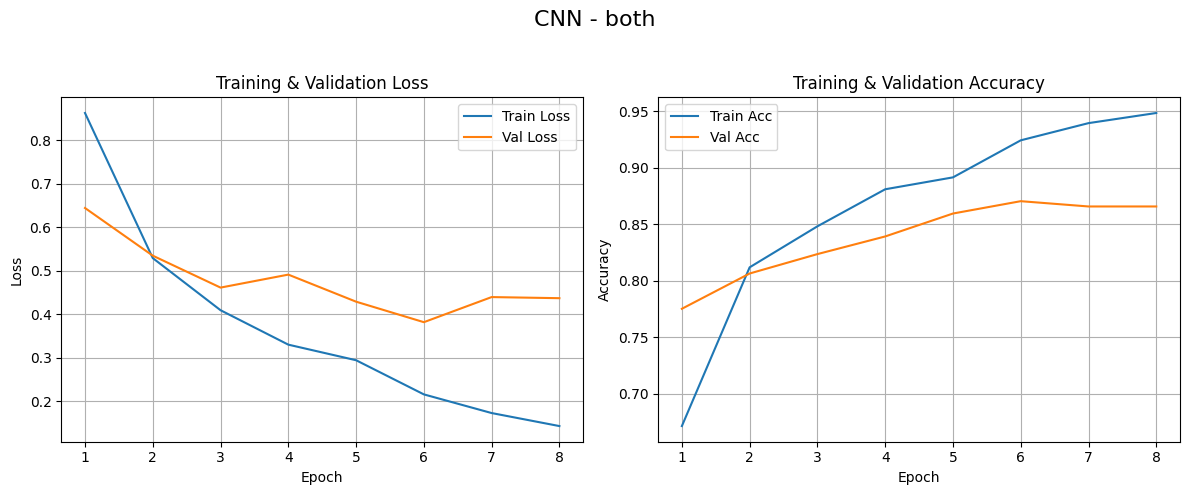

Accuracy: 0.8594
Classification Report:
               precision    recall  f1-score   support

           N       0.99      0.85      0.92     18118
           S       0.25      0.79      0.38       556
           V       0.70      0.87      0.78      1448
           F       0.15      0.91      0.25       162
           Q       0.91      0.94      0.93      1608

    accuracy                           0.86     21892
   macro avg       0.60      0.87      0.65     21892
weighted avg       0.94      0.86      0.89     21892



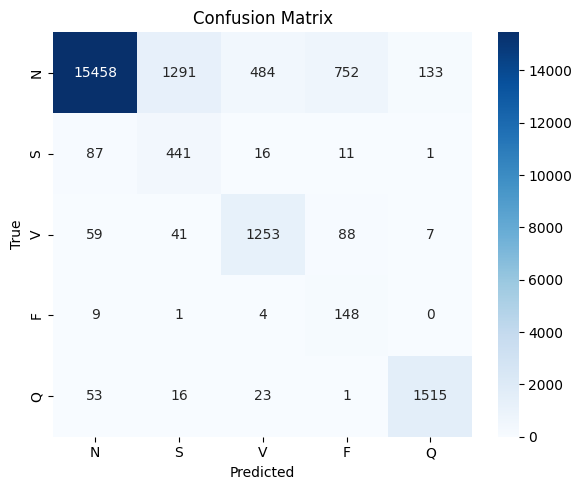

In [12]:
plot_classifier_curves(
    log_path=log_path_3,
    suptitle='CNN - both'
)

evaluate_classifier(
    model=model_3,
    dataloader=test_loader_3,
    class_names=class_names,
    device=device
)

## Model 4: ResNet - both

In [13]:
train_dataset = ECGDataset(signals=X_train,
                           labels=y_train,
                           gaf_mode='both')
val_dataset = ECGDataset(signals=X_val,
                         labels=y_val,
                         gaf_mode='both')
test_dataset = ECGDataset(signals=X_test,
                          labels=y_test,
                          gaf_mode='both')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE)
test_loader_4 = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE)


model_4 = build_resnet(in_channels=2)
train_model(model=model_4,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            num_epochs=20,
            log_path=log_path_4,
            model_path=model_path_4,
            patience=2)

c:\Projects\python\algorithms\mainenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Projects\python\algorithms\mainenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 | Train Loss: 0.6885 | Train Acc: 0.7555 | Val Loss: 1.2403 | Val Acc: 0.6537 | Patience: 0
Epoch 2/20 | Train Loss: 0.4771 | Train Acc: 0.8393 | Val Loss: 0.5228 | Val Acc: 0.8144 | Patience: 0
Epoch 3/20 | Train Loss: 0.4546 | Train Acc: 0.8405 | Val Loss: 0.3921 | Val Acc: 0.8752 | Patience: 0
Epoch 4/20 | Train Loss: 0.3345 | Train Acc: 0.8892 | Val Loss: 0.3800 | Val Acc: 0.8752 | Patience: 0
Epoch 5/20 | Train Loss: 0.4010 | Train Acc: 0.8670 | Val Loss: 0.3689 | Val Acc: 0.8892 | Patience: 1
Epoch 6/20 | Train Loss: 0.2637 | Train Acc: 0.9091 | Val Loss: 0.3776 | Val Acc: 0.8643 | Patience: 0
Epoch 7/20 | Train Loss: 0.2990 | Train Acc: 0.8998 | Val Loss: 0.5040 | Val Acc: 0.8580 | Patience: 1
Early stopping triggered!


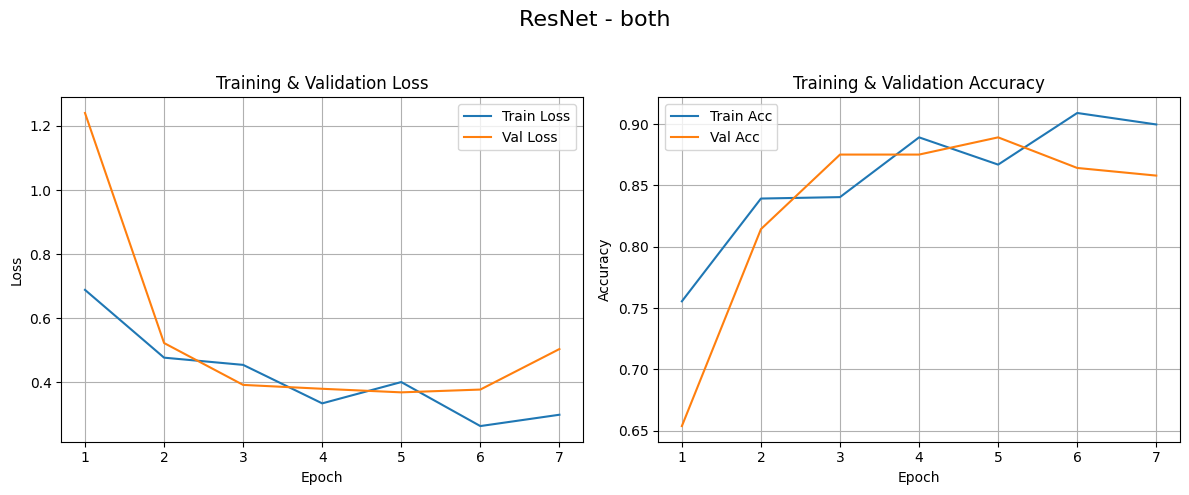

Accuracy: 0.9064
Classification Report:
               precision    recall  f1-score   support

           N       0.97      0.92      0.95     18118
           S       0.27      0.79      0.40       556
           V       0.90      0.82      0.86      1448
           F       0.35      0.81      0.49       162
           Q       0.99      0.87      0.92      1608

    accuracy                           0.91     21892
   macro avg       0.70      0.84      0.72     21892
weighted avg       0.95      0.91      0.92     21892



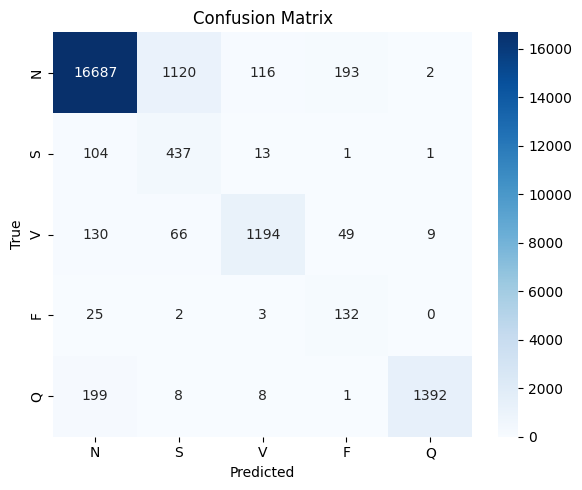

In [14]:
plot_classifier_curves(
    log_path=log_path_4,
    suptitle='ResNet - both'
)

evaluate_classifier(
    model=model_4,
    dataloader=test_loader_4,
    class_names=class_names,
    device=device
)